In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
from scipy import stats
import networkx as nx
import seaborn as sns
import re
import sys
sys.path.append("../scripts/")
from nn_check_randomization_simple_mlp_new import *

plt.style.use("../config/custom_plt.mplstyle")

plt.rc('text', usetex=False)

In [2]:
%%time 

dataset = 'Fashion-MNIST'
hidden_size = [64]

num_samples_per_class = 100000

# Easy task
class1 = 3
class2 = 2

activation_fn = ''


all_fraction_non_zero = [1, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 
                             0.15, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.001]
sparsification_levels = [1 - x for x in all_fraction_non_zero]

all_res_easy = []

for i in tqdm(range(100)):
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    res_easy = randomize_mlp(9, path, [class1, class2], num_samples_per_class, 
                        hidden_size, dataset, verbose=False, sparsification_levels=sparsification_levels)
    all_res_easy.append(res_easy)

100%|██████████| 100/100 [8:32:26<00:00, 307.47s/it] 

CPU times: user 6d 5h 18min 49s, sys: 13min 29s, total: 6d 5h 32min 18s
Wall time: 8h 32min 26s


In [3]:
%%time 

# Hard task
class1 = 3
class2 = 1

all_res_hard = []

for i in tqdm(range(100)):
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    res_hard = randomize_mlp(9, path, [class1, class2], num_samples_per_class, 
                            hidden_size, dataset, verbose=False, sparsification_levels=sparsification_levels)
    all_res_hard.append(res_hard)

100%|██████████| 100/100 [7:58:19<00:00, 287.00s/it] 

CPU times: user 5d 18h 51min 54s, sys: 11min 32s, total: 5d 19h 3min 27s
Wall time: 7h 58min 19s


In [4]:
def plot_shaded_area(x, data, plot_style='median_iqr', label='', color='blue', alpha=0.2, linestyle='-'):
    """
    Plots a shaded area with a central line based on the provided data.
    
    Parameters:
      x (array-like): x-axis values.
      data (np.ndarray): 2D array where each row corresponds to a run.
      plot_style (str): 'mean_std' for mean ± standard deviation,
                        'median_iqr' for median with interquartile range.
      label (str): Label for the central line.
      color (str): Color for the shaded area and line.
      alpha (float): Transparency for the shaded area.
    """
    if plot_style == 'mean_std':
        central = np.mean(data, axis=1)
        lower = central - np.std(data, axis=1)
        upper = central + np.std(data, axis=1)
    elif plot_style == 'median_iqr':
        central = np.median(data, axis=1)
        lower = np.percentile(data, 25, axis=1)
        upper = np.percentile(data, 75, axis=1)
    else:
        raise ValueError("Unsupported plot_style. Use 'mean_std' or 'median_iqr'.")
    plt.fill_between(x, lower, upper, alpha=alpha, color=color)
    plt.plot(x, central, color=color, label=label, linestyle=linestyle)

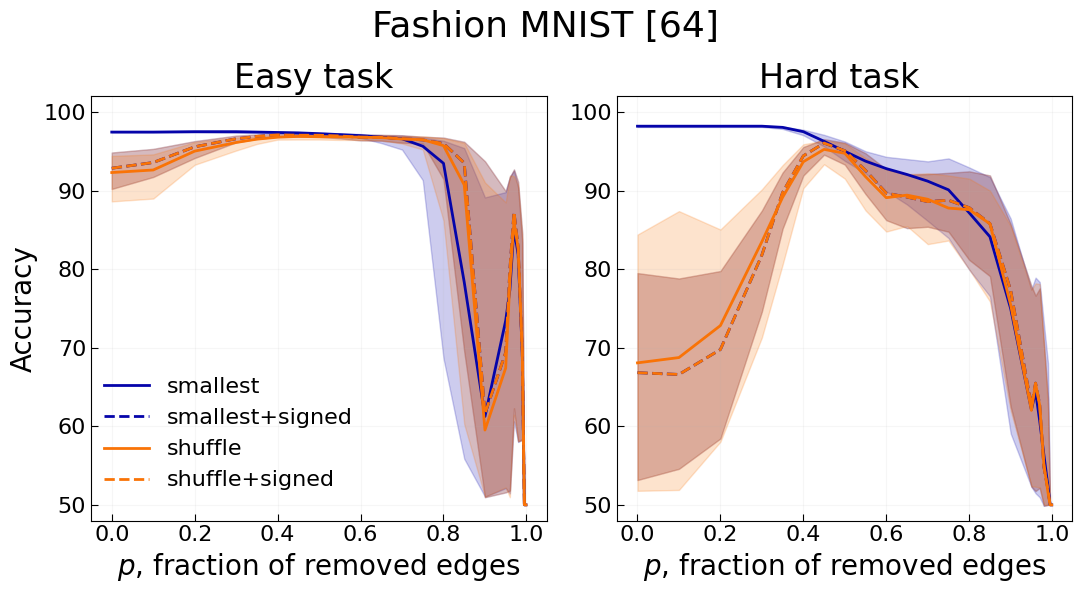

In [5]:
plt.figure(figsize=(11, 6))

### EASY TASK
plt.subplot(1, 2, 1)

total_original_accuracy, total_original_signed_accuracy = [], [] 
total_random_1 = []
total_signed_random_1 = []

for sparse_level in sparsification_levels:
    
    all_original_accuracy, all_original_signed_accuracy = [], [] 
    all_random_1 = []
    all_signed_random_1 = []

    for i in range(len(all_res_easy)):
        original_accuracy, original_signed_accuracy, random_accuracy, random_signed_accuracy = all_res_easy[i]

        all_original_accuracy.append(original_accuracy[sparse_level])
        all_original_signed_accuracy.append(original_signed_accuracy[sparse_level])

        all_random_1.append(random_accuracy[sparse_level]['random_pos_neg'])# if random_accuracy[sparse_level]['random_pos_neg'] > 50 else 100 - random_accuracy[sparse_level]['random_pos_neg'])
        all_signed_random_1.append(random_signed_accuracy[sparse_level]['random_pos_neg'])# if random_signed_accuracy[sparse_level]['random_pos_neg'] > 50 else 100 - random_signed_accuracy[sparse_level]['random_pos_neg'])

    total_original_accuracy.append(all_original_accuracy)
    total_original_signed_accuracy.append(all_original_signed_accuracy)
    total_random_1.append(all_random_1)
    total_signed_random_1.append(all_signed_random_1)


plot_shaded_area(sparsification_levels, np.array(total_original_accuracy), 
                 plot_style='median_iqr', label='smallest', color='xkcd:royal blue')
plot_shaded_area(sparsification_levels, np.array(total_original_signed_accuracy),
                plot_style='median_iqr', label='smallest+signed', color='xkcd:royal blue', linestyle='--')
plot_shaded_area(sparsification_levels, np.array(total_random_1),
                plot_style='median_iqr', label='shuffle', color='xkcd:orange')
plot_shaded_area(sparsification_levels, np.array(total_signed_random_1),
                plot_style='median_iqr', label='shuffle+signed', color='xkcd:orange', linestyle='--')

plt.legend(loc=(0.01, 0.05))
plt.title(f'Easy task ')
plt.ylabel('Accuracy')
plt.xlabel('$p$, fraction of removed edges')
plt.ylim(48, 102)


### HARD TASK
plt.subplot(1, 2, 2)
total_original_accuracy, total_original_signed_accuracy = [], [] 
total_random_1 = []
total_signed_random_1 = []

for sparse_level in sparsification_levels:
    all_original_accuracy, all_original_signed_accuracy = [], [] 
    all_random_1 = []
    all_signed_random_1 = []

    for i in range(len(all_res_easy)):
        original_accuracy, original_signed_accuracy, random_accuracy, random_signed_accuracy = all_res_hard[i]

        all_original_accuracy.append(original_accuracy[sparse_level])
        all_original_signed_accuracy.append(original_signed_accuracy[sparse_level])

        all_random_1.append(random_accuracy[sparse_level]['random_pos_neg']) #if random_accuracy[sparse_level]['random_pos_neg'] > 50 else 100 - random_accuracy[sparse_level]['random_pos_neg'])
        all_signed_random_1.append(random_signed_accuracy[sparse_level]['random_pos_neg']) #if random_signed_accuracy[sparse_level]['random_pos_neg'] > 50 else 100 - random_signed_accuracy[sparse_level]['random_pos_neg'])

    total_original_accuracy.append(all_original_accuracy)
    total_original_signed_accuracy.append(all_original_signed_accuracy)
    total_random_1.append(all_random_1)
    total_signed_random_1.append(all_signed_random_1)

plot_shaded_area(sparsification_levels, np.array(total_original_accuracy), 
                 plot_style='median_iqr', label='smallest', color='xkcd:royal blue')
plot_shaded_area(sparsification_levels, np.array(total_original_signed_accuracy),
                plot_style='median_iqr', label='smallest+signed', color='xkcd:royal blue', linestyle='--')
plot_shaded_area(sparsification_levels, np.array(total_random_1),
                plot_style='median_iqr', label='shuffle', color='xkcd:orange')
plot_shaded_area(sparsification_levels, np.array(total_signed_random_1),
                plot_style='median_iqr', label='shuffle+signed', color='xkcd:orange', linestyle='--')

plt.title(f'Hard task ')
plt.xlabel('$p$, fraction of removed edges')
plt.ylim(48, 102)

plt.suptitle(f"Fashion MNIST [{hidden_size[0]}]", fontsize=26)
plt.tight_layout()


In [6]:
randomization_types = ['random', 'random_pos_neg',
                       'keep_total_strength_left', 'keep_total_strength_right',
                       'keep_pos_neg_strength_left', 'keep_pos_neg_strength_right',
                       'keep_in_out_degree_swap_edges']


randomization_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [7]:
all_original_accuracy_easy = []
all_original_signed_accuracy_easy = []
all_random_accuracy_easy = {}
all_random_signed_accuracy_easy = {}

for i in range(len(all_res_easy)):
    
    original_accuracy, original_signed_accuracy, random_accuracy, random_signed_accuracy = all_res_easy[i]
    
    # Without sparsification
    original_accuracy = original_accuracy[0]
    original_signed_accuracy = original_signed_accuracy[0]
    random_accuracy = random_accuracy[0]
    random_signed_accuracy = random_signed_accuracy[0]
    
    for r in randomization_types:
        
        if r not in all_random_accuracy_easy:
            all_random_accuracy_easy[r] = []
        if r not in all_random_signed_accuracy_easy:
            all_random_signed_accuracy_easy[r] = []
            
        all_random_accuracy_easy[r].append(random_accuracy[r])
        all_random_signed_accuracy_easy[r].append(random_signed_accuracy[r])
    
    all_original_accuracy_easy.append(original_accuracy)
    all_original_signed_accuracy_easy.append(original_signed_accuracy)

In [8]:
all_original_accuracy_hard = []
all_original_signed_accuracy_hard = []
all_random_accuracy_hard = {}
all_random_signed_accuracy_hard = {}

for i in range(len(all_res_easy)):
    
    original_accuracy, original_signed_accuracy, random_accuracy, random_signed_accuracy = all_res_hard[i]
    
    # Without sparsification
    original_accuracy = original_accuracy[0]
    original_signed_accuracy = original_signed_accuracy[0]
    random_accuracy = random_accuracy[0]
    random_signed_accuracy = random_signed_accuracy[0]
    
    for r in randomization_types:
        
        if r not in all_random_accuracy_hard:
            all_random_accuracy_hard[r] = []
        if r not in all_random_signed_accuracy_hard:
            all_random_signed_accuracy_hard[r] = []
            
        all_random_accuracy_hard[r].append(random_accuracy[r])
        all_random_signed_accuracy_hard[r].append(random_signed_accuracy[r])
    
    all_original_accuracy_hard.append(original_accuracy)
    all_original_signed_accuracy_hard.append(original_signed_accuracy)

/tmp/ipykernel_3132720/2406591489.py:70: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_3132720/2406591489.py:88: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


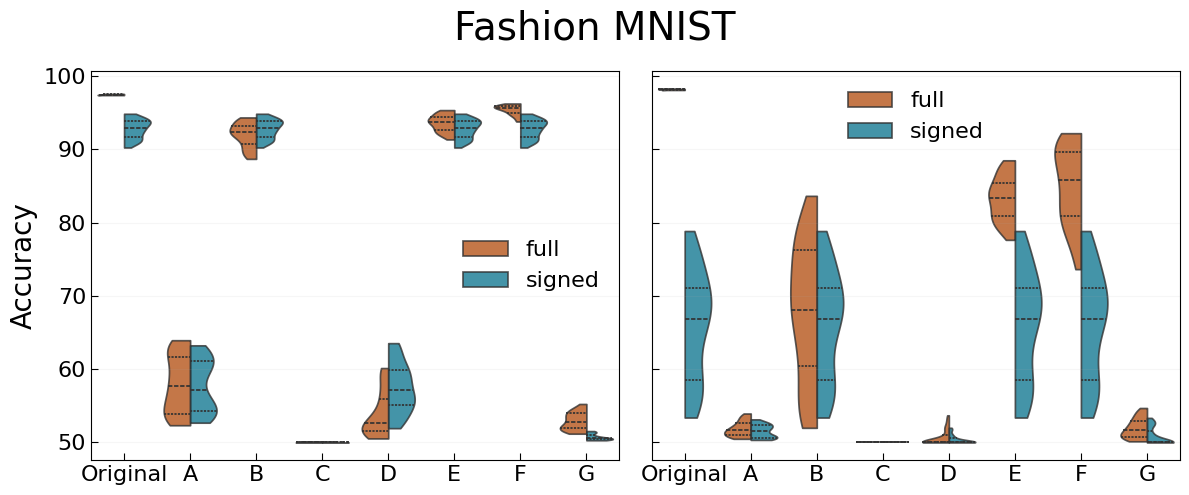

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) helper to flip any value below 50
def flip50(data):
    return [100 - x if x < 50 else x for x in data]

# 1) helper to trim to central 95%
# def trim_ci(data, lower=2.5, upper=97.5):
def trim_ci(data, lower=25, upper=75):
    lo, hi = np.percentile(data, [lower, upper])
    return [x for x in data if lo <= x <= hi]

### EASY 
cats, vals, hues = [], [], []

# original
orig_flipped = flip50(all_original_accuracy_easy)
sign_flipped = flip50(all_original_signed_accuracy_easy)

full_trimmed   = trim_ci(orig_flipped)
signed_trimmed = trim_ci(sign_flipped)

cats  += ['Original'] * (len(full_trimmed) + len(signed_trimmed))
vals  += full_trimmed + signed_trimmed
hues  += ['full'] * len(full_trimmed) + ['signed'] * len(signed_trimmed)

# each randomization
for i, r in enumerate(randomization_types):
    f = trim_ci(flip50(all_random_accuracy_easy[r]))
    s = trim_ci(flip50(all_random_signed_accuracy_easy[r]))
    cats += [randomization_labels[i]] * (len(f) + len(s))
    vals += f + s
    hues += ['full'] * len(f) + ['signed'] * len(s)

df_easy = pd.DataFrame({'Category': cats, 'Accuracy': vals, 'Type': hues})


### HARD
cats, vals, hues = [], [], []

# original
orig_flipped = flip50(all_original_accuracy_hard)
sign_flipped = flip50(all_original_signed_accuracy_hard)

full_trimmed   = trim_ci(orig_flipped)
signed_trimmed = trim_ci(sign_flipped)

cats  += ['Original'] * (len(full_trimmed) + len(signed_trimmed))
vals  += full_trimmed + signed_trimmed
hues  += ['full'] * len(full_trimmed) + ['signed'] * len(signed_trimmed)

# each randomization
for i, r in enumerate(randomization_types):
    f = trim_ci(flip50(all_random_accuracy_hard[r]))
    s = trim_ci(flip50(all_random_signed_accuracy_hard[r]))
    cats += [randomization_labels[i]] * (len(f) + len(s))
    vals += f + s
    hues += ['full'] * len(f) + ['signed'] * len(s)

df_hard = pd.DataFrame({'Category': cats, 'Accuracy': vals, 'Type': hues})


# --- 3) Plot ---

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

sns.violinplot(
    x='Category',
    y='Accuracy',
    hue='Type',
    data=df_easy,
    split=True,
    inner='quart',
    scale='width',
    cut=0,
    palette={'full': '#d04e00', 'signed': '#0086a8'},
    alpha=0.8,
    ax=axes[0]
)

axes[0].set_xlabel('Accuracy')
axes[0].set_xlabel('')
axes[0].legend(title='')

sns.violinplot(
    x='Category',
    y='Accuracy',
    hue='Type',
    data=df_hard,
    split=True,
    inner='quart',
    scale='width',
    cut=0,
    palette={'full': '#d04e00', 'signed': '#0086a8'},
    alpha=0.8,
    ax=axes[1]
)

axes[1].set_xlabel('')
axes[1].legend(title='')
fig.suptitle('Fashion MNIST', fontsize=28)

plt.tight_layout()


/tmp/ipykernel_3132720/849718499.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


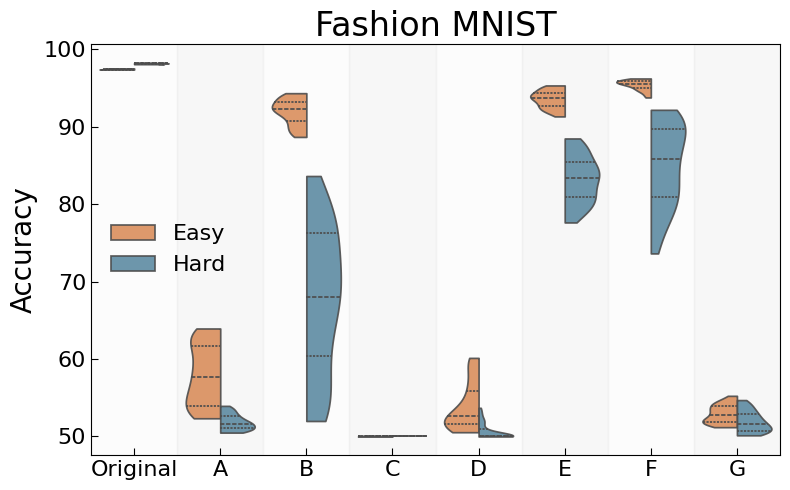

In [13]:
df_easy['Difficulty'] = 'Easy'
df_hard['Difficulty'] = 'Hard'

# 2) merge into one
df_all = pd.concat([df_easy, df_hard], ignore_index=True)
df_all = df_all[df_all['Type'] == 'full']

plt.figure(figsize=(8, 5))
ax = sns.violinplot(
    x='Category',
    y='Accuracy',
    hue='Difficulty',
    data=df_all,
    split=True,          # halves for easy vs hard
    inner='quart',       # show quartiles
    scale='width',       # same max width
    cut=0,               # no tails beyond data
    alpha=0.9,
    palette={'Easy': '#ef8a47', 'Hard': '#528fad'}
)


categories = df_all['Category'].unique()
for i, category in enumerate(categories):
    if i % 2 == 0:
        color = '#f0f0f0'  # lighter grey
    else:
        color = '#d9d9d9'  # darker grey
    ax.axvspan(i - 0.5, i + 0.5, color=color, zorder=-1, alpha=0.2)

ax.set_xlim(-0.5, 7.5)
ax.grid(False)


plt.ylabel('Accuracy')
plt.xlabel('')
plt.title('Fashion MNIST')
plt.legend(title='')
plt.tight_layout()

# plt.savefig("../plots/paper/randomize_boxplots_fashion_mnist_v2.pdf")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) tag Difficulty
df_easy['Difficulty'] = 'Easy'
df_hard['Difficulty'] = 'Hard'

# 2) merge into one and filter
df_all = pd.concat([df_easy, df_hard], ignore_index=True)
df_all = df_all[df_all['Type'] == 'full']

palette = {'Easy': '#ef8a47', 'Hard': '#528fad'}
alpha = 1       # set your desired transparency here
linewidth = 2     # thickness for box borders

plt.figure(figsize=(8, 5))
ax = sns.boxplot(
    x='Category',
    y='Accuracy',
    hue='Difficulty',
    data=df_all,
    width=0.6,
    palette=palette,
    fliersize=0,
    dodge=True,
    linewidth=linewidth,
    boxprops={'linewidth': linewidth},
    whiskerprops={'linewidth': linewidth},
    capprops={'linewidth': linewidth},
    medianprops={'linewidth': 0},   # ← hide median line
)

# set same alpha on all box patches
for patch in ax.artists:
    patch.set_alpha(alpha)

# add alternating background shading
categories = list(df_all['Category'].unique())
for i in range(len(categories)):
    bg_color = '#f0f0f0' if i % 2 == 0 else '#d9d9d9'
    ax.axvspan(i - 0.5, i + 0.5, color=bg_color, zorder=-1, alpha=0.2)

ax.set_xlim(-0.5, len(categories) - 0.5)
ax.grid(False)

# overlay median points with same colors+alpha
median_df = (
    df_all
    .groupby(['Category', 'Difficulty'])['Accuracy']
    .median()
    .reset_index()
)
offsets = {'Easy': -0.15, 'Hard': 0.15}

for _, row in median_df.iterrows():
    idx = categories.index(row['Category'])
    x = idx + offsets[row['Difficulty']]
    ax.scatter(
        x,
        row['Accuracy'],
        marker='o',
        s=120,
        facecolor=palette[row['Difficulty']],
        edgecolor='black',
        linewidth=2,
        alpha=alpha,
        zorder=3
    )

# labels & legend
ax.set_xlabel('')
ax.set_ylabel('Accuracy')
ax.set_title('Fashion MNIST')
ax.legend(title='')
plt.tight_layout()

# plt.savefig("../plots/paper/randomize_boxplots_fashion_mnist_v3.pdf")

In [ ]:
plt.figure(figsize=(11, 6))

randomization_types  = ['random_pos_neg',
                        'keep_pos_neg_strength_left',
                        'keep_pos_neg_strength_right']
randomization_labels = ['B',
                        'E',
                        'F']
random_colors        = ['xkcd:orange', 'xkcd:green', 'xkcd:red']
baseline_color       = 'xkcd:royal blue'

def plot_subset(all_res, title, ax_idx):
    plt.subplot(1, 2, ax_idx)
    
    # 1) Collect baseline (original) accuracy across sparsification levels
    baseline = []
    for p in sparsification_levels:
        baseline.append([
            orig_acc[p]
            for (orig_acc, orig_signed, rand_acc, rand_signed) in all_res
        ])
    
    # 2) Collect randomization accuracies
    totals = {rtype: [] for rtype in randomization_types}
    for p in sparsification_levels:
        tmp = {rtype: [] for rtype in randomization_types}
        for (_, _, rand_acc, _) in all_res:
            for rtype in randomization_types:
                tmp[rtype].append(rand_acc[p][rtype])
        for rtype in randomization_types:
            totals[rtype].append(tmp[rtype])
    
    # 3) Plot the original baseline
    plot_shaded_area(sparsification_levels, np.array(baseline),
                     plot_style='median_iqr',
                     label='original', 
                     color=baseline_color)
    
    # 4) Plot each randomization mode
    for rtype, label, col in zip(randomization_types, randomization_labels, random_colors):
        data = np.array(totals[rtype])
        plot_shaded_area(sparsification_levels, data,
                         plot_style='median_iqr',
                         label=label,
                         color=col)

    plt.title(title)
    plt.xlabel('$p$, fraction of removed edges')
    plt.ylim(48, 102)
    if ax_idx == 1:
        plt.ylabel('Accuracy')
    if ax_idx == 1:
        plt.legend(loc='lower left')

plot_subset(all_res_easy, 'Easy task', ax_idx=1)
plot_subset(all_res_hard, 'Hard task', ax_idx=2)

plt.suptitle(f"Fashion MNIST [{hidden_size[0]}]", fontsize=26)
plt.tight_layout()


In [ ]:
colors = ['#ef8a47', '#528fad']

plt.figure(figsize=(15, 5))

for idx, (rtype, label, col) in enumerate(zip(randomization_types,
                                              randomization_labels,
                                              random_colors), start=1):
    ax = plt.subplot(1, 3, idx)

    # 1) Baseline easy
    baseline_easy = np.array([
        [orig_acc[p] for (orig_acc, _, _, _) in all_res_easy]
        for p in sparsification_levels
    ])
    # 2) Baseline hard
    baseline_hard = np.array([
        [orig_acc[p] for (orig_acc, _, _, _) in all_res_hard]
        for p in sparsification_levels
    ])

    # 3) Randomized easy
    rand_easy = np.array([
        [rand_acc[p][rtype] for (_, _, rand_acc, _) in all_res_easy]
        for p in sparsification_levels
    ])
    # 4) Randomized hard
    rand_hard = np.array([
        [rand_acc[p][rtype] for (_, _, rand_acc, _) in all_res_hard]
        for p in sparsification_levels
    ])

    # plot_shaded_area(x, data, ...)
#     plot_shaded_area(sparsification_levels, baseline_easy,
#                      plot_style='median_iqr',
#                      label='Original Easy',
#                      color=baseline_color,
#                      linestyle='-')
#     plot_shaded_area(sparsification_levels, baseline_hard,
#                      plot_style='median_iqr',
#                      label='Original Hard',
#                      color=baseline_color,
#                      linestyle='--')

    plot_shaded_area(sparsification_levels, rand_easy,
                     plot_style='median_iqr',
                     label=f'Easy',
                     color=colors[0],
                     linestyle='-')
    plot_shaded_area(sparsification_levels, rand_hard,
                     plot_style='median_iqr',
                     label=f'Hard',
                     color=colors[1],
                     linestyle='-')

    ax.set_title(f'Randomization {label}')
    ax.set_xlabel('$p$, fraction of removed edges')
    if idx == 1:
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower left')
    ax.set_ylim(48, 102)

plt.suptitle(f"Fashion MNIST", fontsize=26)
plt.tight_layout()

# plt.savefig("../plots/paper/randomize_prune_fashion_mnist_d64.pdf")
# plt.savefig("../plots/paper/randomize_prune_fashion_mnist_d32.pdf")
# plt.savefig("../plots/paper/randomize_prune_fashion_mnist_d128.pdf")

# plt.savefig("../plots/paper/randomize_prune_fashion_mnist_d64_sigmoid.pdf")